In [94]:
import csv
import os
from functools import partial
import json

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper
from gerrychain.proposals import recom, flip
from gerrychain.updaters import cut_edges

import tqdm

In [95]:
unique_label = "GEOID10"
pop_col = "TOTPOP"
district_col = "CD"

plot_path = "./IA-shapefiles/IA_counties/IA_counties.shp"
graph = Graph.from_json("iowa.json")

In [96]:
df = gpd.read_file(plot_path)

In [97]:
def num_splits(partition):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby("COUNTYFP10")["current"].nunique() > 1)
    return splits

In [98]:
updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges, "black_pop": updaters.Tally("BPOP", alias = "black_pop"),
    "nh_white": updaters.Tally("NH_WHITE", alias = "nh_white"),
    "nh_black": updaters.Tally("NH_BLACK", alias = "nh_black"),
    "hisp": updaters.Tally("HISP", alias = "hisp"),
    "vap": updaters.Tally("VAP", alias = "vap"),
    "hvap": updaters.Tally("HVAP", alias = "hvap"),
    "wvap": updaters.Tally("WVAP", alias = "wvap"),
    "bvap":updaters.Tally("BVAP", alias = "bvap")
}

In [99]:
initial_partition = Partition(graph, "CD", updaters)

In [100]:
ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition)

In [101]:
proposal = partial(
    recom, pop_col="TOTPOP", pop_target=ideal_population, epsilon=0.02, node_repeats=2
)

In [102]:
def cut_length(partition):
    return len(partition["cut_edges"])

compactness_bound = constraints.UpperBound(
    cut_length, 2 * cut_length(initial_partition)
)

In [207]:
chain_length = 20000

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.02),
        compactness_bound # single_flip_contiguous#no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=chain_length,
)

pop = []
cut_edges = []
nh_white = []
nh_black = []
hisp = []
vap = []
hvap = []
wvap = []
bvap = []
splits = []
pop_metrics = {}

t = 0
for part in chain.with_progress_bar():
    splits.append(num_splits(part))
    pop.append(list(part["population"].values()))
    cut_edges.append(len(part["cut_edges"]))
    nh_white.append(list(part["nh_white"].values()))
    nh_black.append(list(part["nh_black"].values()))
    hisp.append(list(part["hisp"].values()))
    vap.append(list(part["vap"].values()))
    hvap.append(list(part["hvap"].values()))
    wvap.append(list(part["wvap"].values()))
    bvap.append(list(part["bvap"].values()))
    pop_metrics.update([("nh_white_pct", np.divide(nh_white,pop)), ("nh_black_pct",np.divide(nh_black, pop)), ("hisp_pct",np.divide(hisp, pop)), ("hvap_pct", np.divide(hvap, vap)), ("wvap_pct", np.divide(wvap, vap)), ("bvap_pct", np.divide(bvap, vap))])
    t += 1

In [208]:
dists = [[pop_metrics["nh_white_pct"][j][i] for j in range(chain_length)] for i in range(4)]

In [209]:
means = [np.mean(dists[i]) for i in range(4)]

In [210]:
centered = []
for i in range(4):
    centered.append(np.subtract(dists[i], [means[i] for j in range(chain_length)]))

In [211]:
centered

[array([ 0.0191752 ,  0.0191752 ,  0.01232089, ..., -0.00091846,
         0.0181783 ,  0.00744987]),
 array([ 0.01375332, -0.02909813, -0.02909813, ...,  0.00785132,
        -0.01138572, -0.00043748]),
 array([-0.02748084,  0.01580662,  0.01580662, ..., -0.02673731,
        -0.02673731, -0.02673731]),
 array([-0.00541553, -0.00541553,  0.00160446, ...,  0.02003943,
         0.02003943,  0.02003943])]

In [212]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform([[centered[i][j] for i in range(4)] for j in range(chain_length)])
principalDf = pd.DataFrame(data = principalComponents
            , columns = ['principal component 1', 'principal component 2'])

In [213]:
principalDf

,principal component 1,principal component 2
0,-0.032249,-0.015410
1,0.027400,-0.026991
2,0.027949,-0.021266
3,0.029884,-0.001811
4,0.027031,-0.001401
5,0.036782,0.001242
6,0.031539,-0.005125
7,0.020212,-0.018039
8,-0.001989,0.002846
9,-0.012285,-0.009037


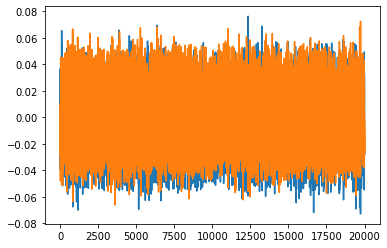

In [214]:
plt.plot(principalDf)

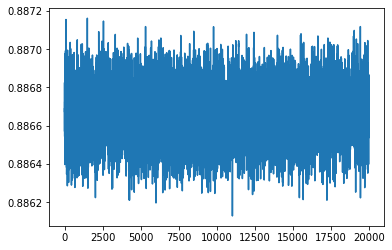

In [215]:
plt.plot([np.mean(pop_metrics["nh_white_pct"][i]) for i in range(chain_length)])

In [221]:
step_sizes = []
for i in range(1, chain_length):
    step_sizes.append(np.mean(pop_metrics["nh_white_pct"][i]) - np.mean(pop_metrics["nh_white_pct"][i-1]))

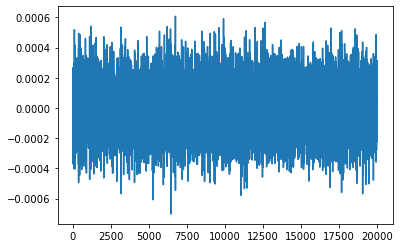

In [222]:
plt.plot(step_sizes)

In [217]:
step_sizes_max = []
for i in range(1, chain_length):
    step_sizes_max.append(np.max(pop_metrics["nh_white_pct"][i]) - np.max(pop_metrics["nh_white_pct"][i-1]))

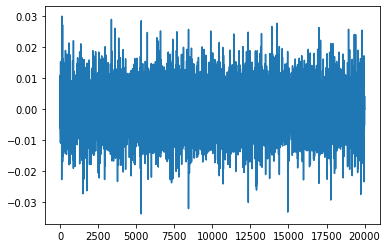

In [218]:
plt.plot(step_sizes_max)

In [219]:
max_min = []
for i in range(chain_length):
    max_min.append(np.divide(np.min(pop_metrics["nh_white_pct"][i]), np.max(pop_metrics["nh_white_pct"][i])))

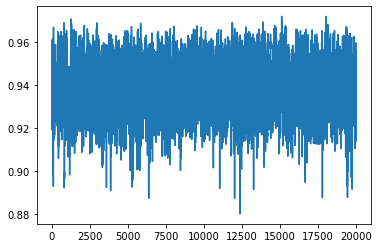

In [220]:
plt.plot(max_min)